In [3]:
!uv pip install jupyterlab-vim

Sourcing .zshenv...
Using Python 3.12.10 environment at: /home/flynn/repos/work/mbo_utilities/.venv
Audited 1 package in 7ms


In [90]:
import numpy as np
from scipy.ndimage import fourier_shift
from skimage.registration import phase_cross_correlation


def _phase_offset(
        frame,
        upsample=10,
        border=0,
        max_offset=3
):
    if frame.ndim == 3:
        frame = frame.mean(axis=0)

    h, w = frame.shape

    if isinstance(border, int):
        t = b = l = r = border
    else:
        t, b, l, r = border

    pre, post = frame[::2], frame[1::2]
    m = min(pre.shape[0], post.shape[0])

    row_start = t
    row_end = m - b if b else m
    col_start = l
    col_end = w - r if r else w

    a = pre[row_start:row_end, col_start:col_end]
    b_ = post[row_start:row_end, col_start:col_end]

    shift, *_ = phase_cross_correlation(a, b_, upsample_factor=upsample)
    dx = float(shift[1])
    if max_offset:
        out = np.sign(dx) * min(abs(dx), max_offset)
        if out != dx:
            print((dx, out))
        return out
    return dx

def _apply_offset(frame, shift):
    rows = frame[1::2]
    f = np.fft.fftn(rows)
    f = fourier_shift(f, (0, shift))
    frame[1::2] = np.fft.ifftn(f).real
    return frame


def compute_scan_phase_offsets(
        arr,
        method="subpix",
        upsample=10,
        max_offset=8,
        border=0
):
    a = np.asarray(arr)
    if a.ndim == 2:
        return _phase_offset(
            a,
            upsample=upsample,
            border=border,
            max_offset=max_offset
        )
    flat = a.reshape(a.shape[0], *a.shape[-2:])
    if method == "subpix":
        return np.array([_phase_offset(
            f,
            upsample=upsample,
            border=border,
            max_offset=max_offset,
        ) for f in flat])  # dtype=np.float32)
    if method == "two_step":
        offs = []
        for f in flat:
            o1 = _phase_offset(
                f,
                upsample=upsample,
                border=border,
                max_offset=max_offset,
            )
            f2 = _apply_offset(f.copy(), o1)
            o2 = _phase_offset(
                f2,
                upsample=upsample,
                border=border,
                max_offset=max_offset,
            )
            offs.append(o1 + o2)
        return np.array(offs, dtype=np.float32)
    raise ValueError(method)


def apply_scan_phase_offsets(arr, offs):
    out = np.asarray(arr).copy()
    if np.isscalar(offs):
        return _apply_offset(out, offs)
    for k, off in enumerate(offs):
        out[k] = _apply_offset(out[k], off)
    return out


In [91]:
files = mbo.get_files("/home/flynn/lbm_data/raw",max_depth=3)

In [92]:
scan = mbo.read_scan("/home/flynn/lbm_data/raw", roi=2)

ic| record.getMessage(): 'MBO Scan initialized.'


In [93]:
data = scan[:, 11, :, :]
data.shape

(1437, 448, 224)

In [94]:
offsets = np.zeros(scan.num_frames, dtype=np.float32)
offsets.shape

(1437,)

In [ ]:
offsets = compute_scan_phase_offsets(scan[:, 11, :, :], upsample=10, border=0, max_offset=1)
offsets

In [55]:
frames = apply_scan_phase_offsets(scan[:, 11, :, :], offsets)

In [50]:
bad_indices = [i for i, off in enumerate(offsets) if abs(off) > 2]
bad_indices

[209, 210, 506, 533]

RFBOutputContext()

JupyterRenderCanvas(css_height='300.0px', css_width='500.0px')
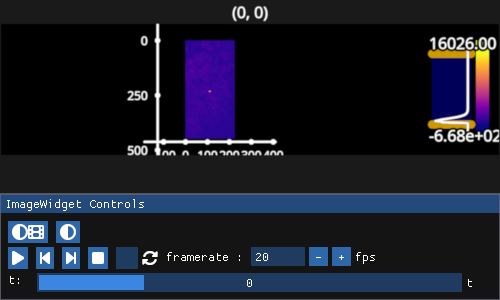

In [56]:
fpl.ImageWidget(frames[bad_indices]).show()

In [18]:
with tifffile.TiffFile(files[0], is_scanimage=False) as tif:
    
    data = tif.asarray()
    h, w = data.shape[1:]
    dtype = data.dtype

    bytes_per_frame = h * w * np.dtype(dtype).itemsize
    max_frames = (50 * 1024**2) // bytes_per_frame  # 50 MB
    sliced = data[:max_frames]
    
print(sliced.shape)

(128, 912, 224)


In [19]:
with open(files[0], 'rb') as f:
    frame_data, roi_data, version = read_scanimage_metadata(f)

    frame_bytes = sliced.shape[1] * sliced.shape[2] * np.dtype(sliced.dtype).itemsize
    max_frames = int((50 * 1024**2) // frame_bytes)
    sliced = full_data[:max_frames]

In [30]:
from tifffile import TiffWriter
import struct
import json

save_path = Path().cwd().parent.joinpath("data")
save_file = save_path.joinpath("demo.tif")

In [51]:
def matlabstr(obj):
    """Convert Python dict to ScanImage-style MATLAB string."""
    def _format(v):
        if isinstance(v, list):
            if all(isinstance(i, str) for i in v):
                return '{' + ' '.join(f"'{i}'" for i in v) + '}'
            return '[' + ' '.join(str(i) for i in v) + ']'
        if isinstance(v, str):
            return f"'{v}'"
        if isinstance(v, bool):
            return 'true' if v else 'false'
        return str(v)

    return '\n'.join(f"{k} = {_format(v)}" for k, v in obj.items())


In [37]:
sp = r"C:\Users\RBO\repos\mbo_utilities\data"
with open(save_file, 'wb') as f:
    # Write ScanImage header manually
    f.write(struct.pack('<2sH', b'II', 43))  # BigTIFF header
    f.seek(16)

    # Fake ScanImage metadata block (exactly like original)
    metadata_bin = bytearray()
    metadata_bin += struct.pack('<IIII', 117637889, version, 0, 0)  # placeholder sizes

    # Serialize static + ROI metadata
    # static_txt = tifffile.matlabstr2py(frame_data).encode('utf-8') + b'\0'
    static_txt = matlabstr(frame_data).encode('utf-8') + b'\0'

    roi_txt = json.dumps(roi_data, separators=(',', ':')).encode('utf-8')

    size0 = len(static_txt)
    size1 = len(roi_txt)
    metadata_bin[8:16] = struct.pack('<II', size0, size1)
    metadata_bin += static_txt
    metadata_bin += roi_txt

    # Write metadata
    f.write(metadata_bin)

    offset_to_first_ifd = f.tell()

In [39]:
type(f)

_io.BufferedWriter

In [55]:
import tifffile
import numpy as np
import shutil

def trim_tiff_frames(input_path, output_path, max_frames=20):
    # Copy original file to preserve metadata
    shutil.copyfile(input_path, output_path)

    with tifffile.TiffFile(input_path, is_scanimage=False) as tif:
        data = tif.asarray()[:max_frames]

    with tifffile.TiffWriter(output_path, bigtiff=True, append=True) as tif_writer:
        for frame in data:
            tif_writer.write(
                frame,
                contiguous=False,
                metadata=None,
                software=None,
                description=None
            )


In [57]:
trim_tiff_frames(
    input_path=files[0],
    output_path=r"..\data\scanimage_trimmed.tif",
    max_frames=50
)

In [58]:
output_path= r"..\data\scanimage_trimmed.tif"
new = tifffile.imread(output_path)

<tifffile.TiffFile 'scanimage_trimmed.tif'> ScanImage series raised ValueError('unable to determine framesPerSlice')


In [11]:
files = mbo.get_files(fname, 'tif', 1)
files

['D:\\W2_DATA\\kbarber\\2025_03_01\\mk301\\green\\mk301_03_01_2025_2roi_17p07hz_224x448px_2umpx_180mw_green_00000.tif',
 'D:\\W2_DATA\\kbarber\\2025_03_01\\mk301\\green\\mk301_03_01_2025_2roi_17p07hz_224x448px_2umpx_180mw_green_00001.tif',
 'D:\\W2_DATA\\kbarber\\2025_03_01\\mk301\\green\\mk301_03_01_2025_2roi_17p07hz_224x448px_2umpx_180mw_green_00002.tif',
 'D:\\W2_DATA\\kbarber\\2025_03_01\\mk301\\green\\mk301_03_01_2025_2roi_17p07hz_224x448px_2umpx_180mw_green_00003.tif',
 'D:\\W2_DATA\\kbarber\\2025_03_01\\mk301\\green\\mk301_03_01_2025_2roi_17p07hz_224x448px_2umpx_180mw_green_00004.tif',
 'D:\\W2_DATA\\kbarber\\2025_03_01\\mk301\\green\\mk301_03_01_2025_2roi_17p07hz_224x448px_2umpx_180mw_green_00005.tif',
 'D:\\W2_DATA\\kbarber\\2025_03_01\\mk301\\green\\mk301_03_01_2025_2roi_17p07hz_224x448px_2umpx_180mw_green_00006.tif',
 'D:\\W2_DATA\\kbarber\\2025_03_01\\mk301\\green\\mk301_03_01_2025_2roi_17p07hz_224x448px_2umpx_180mw_green_00007.tif',
 'D:\\W2_DATA\\kbarber\\2025_03_01\\mk30

In [16]:
data = tifffile.memmap(files[6])

In [98]:
mdata = np.load("/home/flynn/lbm_data/mk301/roi2/plane6/ops.npy", allow_pickle=True).item()
mdata

{'Ly': 448,
 'Lx': 448,
 'fs': np.float64(17.07),
 'nframes': 220,
 'raw_file': '/home/flynn/lbm_data/mk301/roi2/plane6/data_raw.bin',
 'reg_file': '/home/flynn/lbm_data/mk301/roi2/plane6/data_raw.bin',
 'dx': np.float64(2.0),
 'dy': np.float64(2.0),
 'metadata': {'num_planes': 14,
  'fov': [448, 448],
  'fov_px': (224, 448),
  'num_rois': 2,
  'frame_rate': 17.06701142272251,
  'pixel_resolution': array([2., 2.]),
  'ndim': 4,
  'dtype': 'int16',
  'size': 340343808,
  'raw_frames': 119.0,
  'raw_height': 912,
  'raw_width': 224,
  'tiff_pages': 1666,
  'roi_width_px': 224,
  'roi_height_px': 448,
  'objective_resolution': 61,
  'save_path': '/home/flynn/lbm_data/mk301/roi2',
  'roi': 2,
  'shape': (220, 448, 448),
  'dims': ['time', 'width', 'height'],
  'trimmed': [0, 0, 0, 0],
  'nframes': 220,
  'num_frames': 220}}

In [101]:
npy_file = np.memmap("/home/flynn/lbm_data/mk301/roi2/plane6/data_raw.bin", dtype=np.int16, shape=(mdata["Lx"], mdata["Ly"]))

In [104]:
from suite2p.io import BinaryFile
# nframes, Lx, Ly = self.metadata["nframes"], self.metadata["Lx"], self.metadata["Ly"]

In [4]:

def run_plane_bin(plane_dir):
    plane_dir = Path(plane_dir)
    ops_path = plane_dir / "ops.npy"
    if ops_path.exists():
        _ = ic(f"Loading ops from existing file: {ops_path}")
        ops = load_ops(str(ops_path))
    else:
        raise ValueError(f"Invalid ops path: {ops_path}")

    # ops.update(input_format="binary", delete_bin=False, move_bin=False)
    if "nframes" in ops and "n_frames" not in ops:
        ops["n_frames"] = ops["nframes"]
    if "n_frames" not in ops:
        raise KeyError("run_plane_bin: missing frame count (nframes or n_frames)")
    n_frames = ops["n_frames"]

    Ly, Lx = ops["Ly"], ops["Lx"]

    ops["raw_file"] = str((plane_dir / "data_raw.bin").resolve())
    ops["reg_file"] = str((plane_dir / "data.bin").resolve())

    with suite2p.io.BinaryFile(Ly=Ly, Lx=Lx, filename=ops["reg_file"], n_frames=n_frames) as f_reg, \
            suite2p.io.BinaryFile(Ly=Ly, Lx=Lx, filename=ops["raw_file"], n_frames=n_frames) \
                    if "raw_file" in ops and ops["raw_file"] is not None else nullcontext() as f_raw:
    return ops
iw.close()

In [22]:
fig = fpl.Figure()
volume = fig[0,0].add_image_volume(data=data[:500])

# volume.interpolation = "linear"
volume.cmap = "gnuplot2"

RFBOutputContext()

JupyterRenderCanvas(css_height='300.0px', css_width='500.0px')
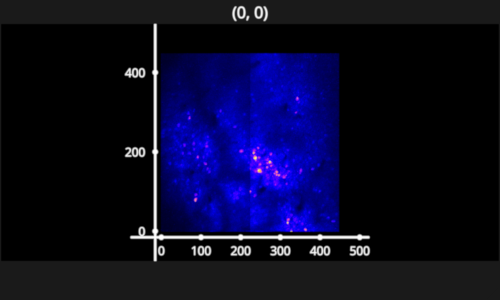

In [23]:
fig.show()

In [9]:
fname_scan = r"D:\W2_DATA\kbarber\2025_03_01\mk301\green\*"
raw_scan = mbo.read_scan(fname_scan)

Detected possible escaped characters in the path. Use a raw string (r'...') or double backslashes.


In [52]:
mbo.save_as(raw_scan, r"D:\W2_DATA\kbarber\2025_03_01\mk301\assembled_zarr", planes=[0, 7, 13], ext=".zarr")

Reading tiff series data...
Reading tiff pages...
Raw tiff fully read.


Saving plane 1:   0%|          | 0/216 [00:00<?, ?it/s]

num-chunks: 216


Saving plane 8:   0%|          | 0/216 [00:00<?, ?it/s]

num-chunks: 216


Saving plane 14:   0%|          | 0/216 [00:00<?, ?it/s]

num-chunks: 216
Time elapsed: 0 minutes 33 seconds.


In [55]:
zpath = r"D:\W2_DATA\kbarber\2025_03_01\mk301\assembled_zarr"
arr = mbo.zarr_to_dask(zpath)